## using statement

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


## Constant

In [ ]:
RANDOM_STATE=42
C=0.01
MAX_ITER=500

## Read data from file

In [133]:
def read_data(path_fake,path_true):
    df_fake=pd.read_csv(path_fake)
    df_true=pd.read_csv(path_true)
    df_fake["label"]="fake"
    df_true["label"]="true"
    df_fake["target"]=0
    df_true["target"]=1

    df=pd.concat([df_fake,df_true],ignore_index=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

In [134]:
df=read_data("Fake.csv","True.csv")

## Clean data

In [135]:
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()                              # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'\@w+|\#','', text)               # remove mentions and hashtags
    text = re.sub(r'[^a-z\s]', '', text)             # remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()         # remove extra whitespace
    return text

In [136]:
def avg_word_length_long_words(text):
    words = text.split()
    long_words = [w for w in words if len(w) >= 4]
    if not long_words:  # avoid division by zero
        return 0
    return sum(len(w) for w in long_words) / len(long_words)

In [137]:
def avg_sentences_length(text):
    # Split by '.', filter out empty sentences
    sentences = [s.strip() for s in text.split('.') if s.strip()]
    if not sentences:
        return 0
    # Count words in each sentence
    sentences_length = [len(s.split()) for s in sentences]
    return np.mean(sentences_length)

In [138]:
def num_word(text):
    return len(text.split())

In [139]:
def num_sentences(text):
    # Split on ., !, ? followed by a space or end of string
    sentences = re.split(r'[.!?]+(?:\s|$)', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    return len(sentences)

In [140]:
def vocabulary_richness(text):
    words=[word for word in text.split()]
    if(len(words)==0):
        return 0
    res=len(set(words)) / len(words)
    return res

In [141]:
def extract_features(text, title):
    words = text.split()
    unique_words = set(words)
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    
    return {
        'num_unique_words': len(unique_words),
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
        'punctuation_count': len(re.findall(r'[^\w\s]', text)),
        'exclamation_count': text.count('!'),
        'question_count': text.count('?'),
        
        'num_uppercase_words': sum(1 for w in words if w.isupper()),
        'title_word_overlap_ratio': len(set(title.lower().split()) & set(text.lower().split())) / len(set(title.lower().split())) if title else 0,
        'contains_hyperlink': int('http' in text or 'www' in text),
    }

In [142]:
def clean_data(df):
    #df['title'] = df['title'].apply(clean_text)
    #df['text'] = df['text'].apply(clean_text)

    df["length_text"]=df["text"].apply(len)
    df["length_title"]=df["title"].apply(len)

    df['text_title_length_relation'] = df.apply(
    lambda row: row['length_text'] / row['length_title'] if row['length_title'] != 0 else 0, axis=1
    )

    df['avg_len_4plus'] = df['text'].apply(avg_word_length_long_words)
    df['avg_len_sentences'] = df['text'].apply(avg_sentences_length)
    df['number_word']=df['text'].apply(num_word)
    df['num_sentences']=df['text'].apply(num_sentences)
    df['vocabulary_richness']=df['text'].apply(vocabulary_richness)
    features_df = df.apply(lambda row: extract_features(row['text'], row['title']), axis=1, result_type='expand')

    df = pd.concat([df, features_df], axis=1)
    df=df.drop(columns=['title','text','subject','date','label'])
    df=df.dropna()
    return df

In [143]:
clean_df=clean_data(df)
clean_df.head()
clean_df.describe()


,target,length_text,length_title,text_title_length_relation,avg_len_4plus,avg_len_sentences,number_word,num_sentences,vocabulary_richness,num_unique_words,avg_word_length,punctuation_count,exclamation_count,question_count,num_uppercase_words,title_word_overlap_ratio,contains_hyperlink
count,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000,44898.000000
mean,0.477015,2469.109693,80.111720,33.353437,6.618982,19.991064,405.282284,16.578110,0.629975,234.238073,5.090994,58.994209,0.407635,0.678605,7.866698,0.609951,0.075794
std,0.499477,2171.617091,25.379685,33.818005,2.191585,6.646325,351.265595,13.819382,0.129091,158.166922,2.175507,66.619461,1.455699,1.794833,10.463373,0.194169,0.264671
min,0.000000,1.000000,8.000000,0.004464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1234.000000,63.000000,14.706337,6.390909,16.333333,203.000000,7.000000,0.568100,138.000000,4.855334,27.000000,0.000000,0.000000,2.000000,0.500000,0.000000
50%,0.000000,2186.000000,73.000000,27.701031,6.608939,19.613836,362.000000,14.000000,0.615956,222.000000,5.072165,48.000000,0.000000,0.000000,5.000000,0.631579,0.000000
75%,1.000000,3105.000000,91.000000,41.903226,6.830769,23.250000,513.000000,22.000000,0.680000,296.000000,5.273764,74.000000,0.000000,1.000000,10.000000,0.750000,0.000000
max,1.000000,51794.000000,286.000000,1713.652174,149.000000,156.000000,8135.000000,328.000000,1.000000,2955.000000,149.000000,7218.000000,133.000000,94.000000,309.000000,1.000000,1.000000


In [144]:
clean_df.head()

,target,length_text,length_title,text_title_length_relation,avg_len_4plus,avg_len_sentences,number_word,num_sentences,vocabulary_richness,num_unique_words,avg_word_length,punctuation_count,exclamation_count,question_count,num_uppercase_words,title_word_overlap_ratio,contains_hyperlink
0,0,1028,89,11.550562,6.575472,24.714286,171,5,0.707602,121.0,4.988304,13.0,0.0,0.0,13.0,0.500000,0.0
1,1,4820,55,87.636364,6.762948,17.750000,771,34,0.538262,415.0,5.249027,139.0,0.0,0.0,20.0,0.875000,0.0
2,1,1848,64,28.875000,6.407035,15.400000,304,16,0.631579,192.0,5.023026,54.0,0.0,0.0,5.0,0.900000,0.0
3,0,1244,89,13.977528,7.308943,14.307692,183,9,0.666667,122.0,5.704918,31.0,0.0,0.0,5.0,0.833333,1.0
4,1,3137,55,57.036364,6.632075,17.225806,529,26,0.606805,321.0,4.928166,84.0,0.0,0.0,10.0,0.900000,0.0


## scatter the text and title length

In [145]:
def scatter_title_text_lenght(df):
    df_0 = df[df['target'] == 0]
    plt.scatter(df_0['length_text'], df_0['length_title'], color='red', label='Target 0')

    # Plot points where target == 1 (green)
    df_1 = df[df['target'] == 1]
    plt.scatter(df_1['length_text'], df_1['length_title'], color='green', label='Target 1')

    # Add labels and legend
    plt.xlabel('Length of Text')
    plt.ylabel('Length of Title')
    plt.title('Text vs Title Length by Target')
    plt.legend()

    # Show plot
    plt.show()


    plt.scatter(df_0['avg_len_4plus'], df_0['text_title_length_relation'], color='red', label='Target 0')
    plt.scatter(df_1['avg_len_4plus'], df_1['text_title_length_relation'], color='green', label='Target 1')
    plt.xlabel('avg_len_4plus')
    plt.ylabel('text_title_length_relation')
    plt.title('text_title_length_relation vs avg_len_4plus  by Target')
    plt.legend()

    # Show plot
    plt.show()


    plt.scatter(df_0['avg_len_sentences'], df_0['number_word'], color='red', label='Target 0')
    plt.scatter(df_1['avg_len_sentences'], df_1['number_word'], color='green', label='Target 1')
    plt.xlabel('avg_len_sentences')
    plt.ylabel('number_word')
    plt.title('number_word vs avg_len_sentences  by Target')
    plt.legend()

    # Show plot
    plt.show()

    
    plt.scatter(df_0['vocabulary_richness'], df_0['num_sentences'], color='red', label='Target 0')
    plt.scatter(df_1['vocabulary_richness'], df_1['num_sentences'], color='green', label='Target 1')
    plt.xlabel('vocabulary_richness')
    plt.ylabel('num_sentences')
    plt.title('num_sentences vs vocabulary_richness  by Target')
    plt.legend()

    # Show plot
    plt.show()

    plt.scatter(df_0['avg_word_length'], df_0['num_unique_words'], color='red', label='Target 0')
    plt.scatter(df_1['avg_word_length'], df_1['num_unique_words'], color='green', label='Target 1')
    plt.xlabel('avg_word_length')
    plt.ylabel('num_unique_words')
    plt.title('num_unique_words vs vocabulavg_word_lengthary_richness  by Target')
    plt.legend()

    # Show plot
    plt.show()

    plt.scatter(df_0['exclamation_count'], df_0['punctuation_count'], color='red', label='Target 0')
    plt.scatter(df_1['exclamation_count'], df_1['punctuation_count'], color='green', label='Target 1')
    plt.xlabel('exclamation_count')
    plt.ylabel('punctuation_count')
    plt.title('punctuation_count vs exclamation_count  by Target')
    plt.legend()

    # Show plot
    plt.show()

    plt.scatter(df_0['num_uppercase_words'], df_0['question_count'], color='red', label='Target 0')
    plt.scatter(df_1['num_uppercase_words'], df_1['question_count'], color='green', label='Target 1')
    plt.xlabel('num_uppercase_words')
    plt.ylabel('question_count')
    plt.title('question_count vs num_uppercase_words  by Target')
    plt.legend()

    # Show plot
    plt.show()

    plt.scatter(df_0['contains_hyperlink'], df_0['title_word_overlap_ratio'], color='red', label='Target 0')
    plt.scatter(df_1['contains_hyperlink'], df_1['title_word_overlap_ratio'], color='green', label='Target 1')
    plt.xlabel('contains_hyperlink')
    plt.ylabel('title_word_overlap_ratio')
    plt.title('title_word_overlap_ratio vs contains_hyperlink  by Target')
    plt.legend()

    # Show plot
    plt.show()

    
    
    

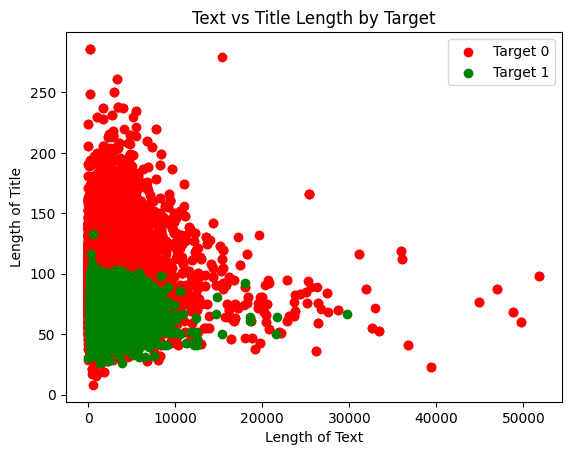

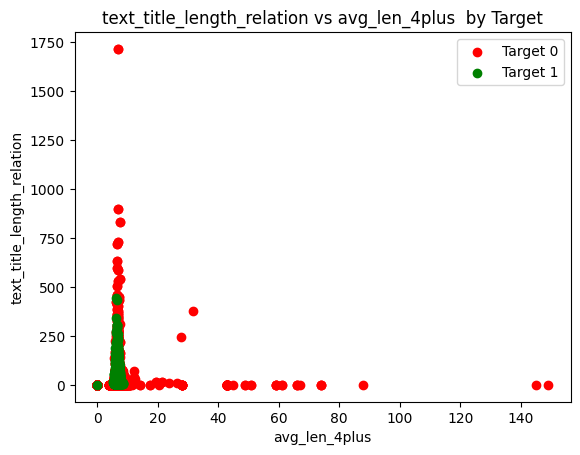

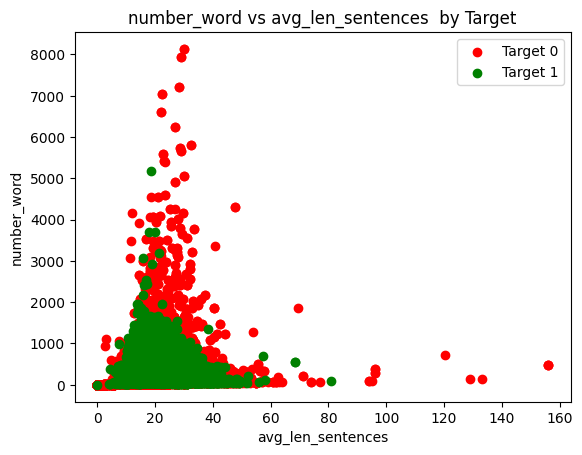

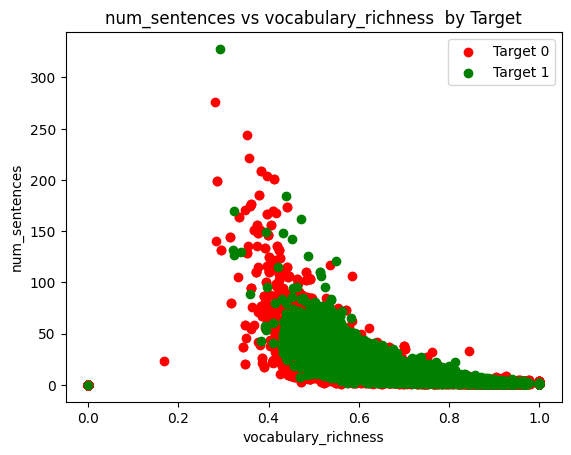

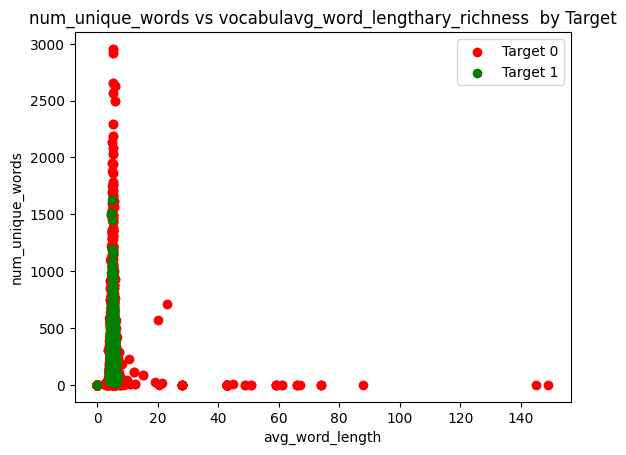

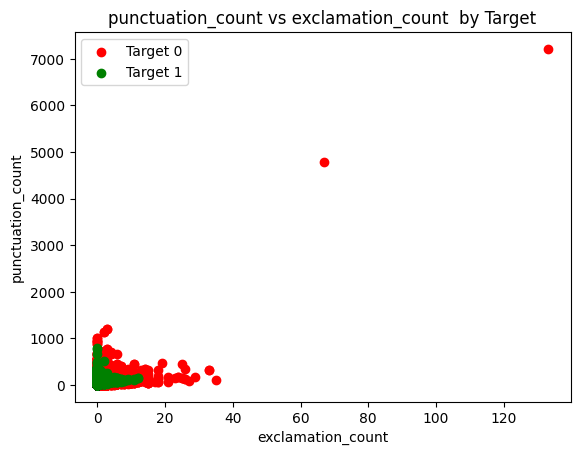

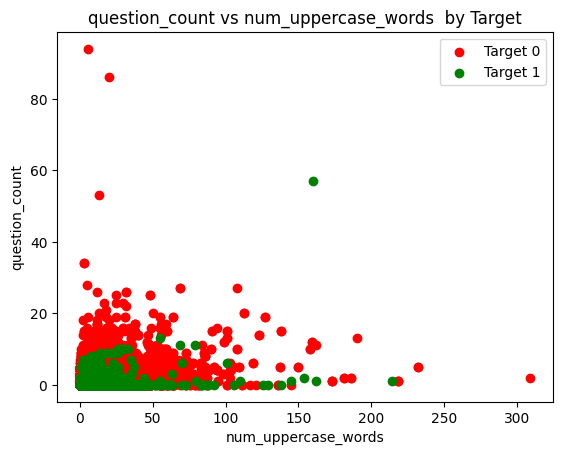

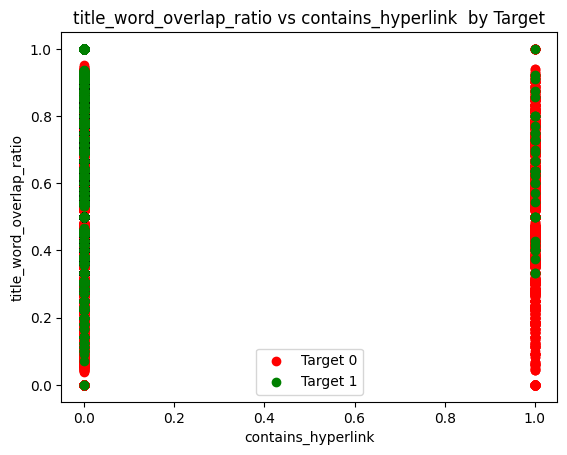

In [146]:
scatter_title_text_lenght(clean_df)

## seperate the X and Y

In [147]:
x_df=clean_df.drop(columns=['target'])
y_df=clean_df["target"]

## split the train test

In [148]:
def split_train_test_valid(x_df,y_df,test_size,valid_size):
    x_train,x_test,y_train,y_test=train_test_split(x_df,y_df,test_size=test_size,random_state=RANDOM_STATE)
    x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train,test_size=valid_size,random_state=RANDOM_STATE)
    return x_train,x_test,x_valid,y_train,y_test,y_valid

In [149]:
x_train,x_test,x_valid,y_train,y_test,y_valid=split_train_test_valid(x_df,y_df,test_size=0.2,valid_size=0.25)

## hyper parameter tuning

In [154]:


def manual_grid_search_linear(x_train, y_train, x_valid, y_valid, param_grid):
    best_model = None
    best_score = 0
    best_params = {}

    for C in param_grid['C']:
        for max_iter in param_grid.get('max_iter', [1000]):
            model = LinearSVC(C=C, max_iter=max_iter)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_valid)
            score = accuracy_score(y_valid, y_pred)

            if score > best_score:
                best_score = score
                best_model = model
                best_params = {'C': C, 'max_iter': max_iter}

    return best_model, best_params, best_score


In [161]:
param_grid = {
    'C': [0.001,0.01, 0.1, 1, 10],
    'max_iter': [100,200,500,1000]
}

best_model, best_params, best_score = manual_grid_search_linear(x_train, y_train, x_valid, y_valid, param_grid)
print(f"best model: {best_model}")
print(f"best parameter: {best_params}")
print(f"best score{best_score}")


best model: LinearSVC(C=0.01, max_iter=100)
best parameter: {'C': 0.01, 'max_iter': 100}
best score0.9330734966592428


In [ ]:
best_model=LinearSVC(C=C,max_iter=MAX_ITER)
best_model.fit(x_train,y_train)
y_pred_train=best_model.predict(x_train)
y_pred_test=best_model.predict(x_test)

train_accuracy=accuracy_score(y_pred_train,y_train)
test_accuracy=accuracy_score(y_pred_test,y_test)

print(f"train accuracy: {train_accuracy}")
print(f"test accuracy: {test_accuracy}")

train accuracy: 0.9297275224589798
test accuracy: 0.9312917594654788


8980
